# Bilevel ROF Scalar Parameter Learning
In this notebook we will propose an optimal parameter learning methodology for getting the optimal parameter for the scalar ROF image denoising model.

$$
\min \|\bar{u}-z\|^2 + \frac{\alpha}{2}\|\lambda\|^2\\
\text{s.t. }\lambda \langle \bar{u},v-\bar{u} \rangle + \|\mathbb{K}v\|_{2,1} - \|\mathbb{K}\bar{u}\|_{2,1} \ge \langle f,v-\bar{u} \rangle
$$

where $\|\cdot\|_{2,1}$ is the Total Variation seminorm.

In [1]:
using LinearAlgebra, StructuredOptimization, AbstractOperators, Plots, Distributed, Images, ImageQualityIndexes

## Test image

In [2]:
m,n = 32,32
f = tril(ones(m,n)) + 0.2*randn(m,n)
f[f .< 0] .= 0.
f[f .> 1] .= 1.
z = tril(ones(m,n));

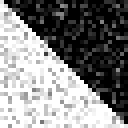

In [3]:
Gray.(f)

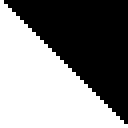

In [4]:
Gray.(z)

## Lower Level Solver and Cost Function

In [24]:
# Lower Level Solver
function lower_level_solver(f,λ,K)
    u = Variable(size(K,1)...)
    @minimize λ*ls(-(1/λ)*K'*u+f) + conj(norm(u,2,1,2)) with ForwardBackward(tol = 1e-15, gamma = 1/8, fast = false) 
    return -(1/λ)*K'*(~u)+f
end

# Upper level cost
function upper_level_cost(u,z,λ,α)
    return 0.5*norm(u[:]-z[:])^2 + 0.5*α*norm(λ)^2 #PSNR
end

upper_level_cost (generic function with 1 method)

In [25]:
K = Variation(size(f))
α = 1e-2

0.01

0.5920326019538366, 6.54889183554149
0.2663596415818602, 11.939410005369679


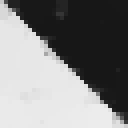

In [26]:
u_h = lower_level_solver(f,8,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,10,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,10,α))")
Gray.(u_h)

In [27]:
step = 0.05
lambda_min = 8.0
lambda_max = 10.0
lambda_range = lambda_min:step:lambda_max
costs = Float64[]
ssims = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(f,λ,K)
    push!(costs,upper_level_cost(u_h,z,λ,α))
    push!(ssims,ssim(u_h,z))
    if λ % 2 == 0
        print("$(round(λ,digits=3)), ")
    end
end

8.0, 10.0, 

Task (done) @0x00000001150e1f90

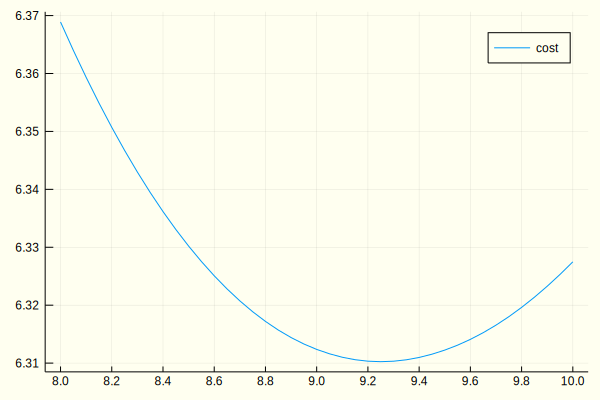

In [28]:
plot(lambda_range,costs,label="cost",xticks = 0:0.2:lambda_max, background_color = :ivory)

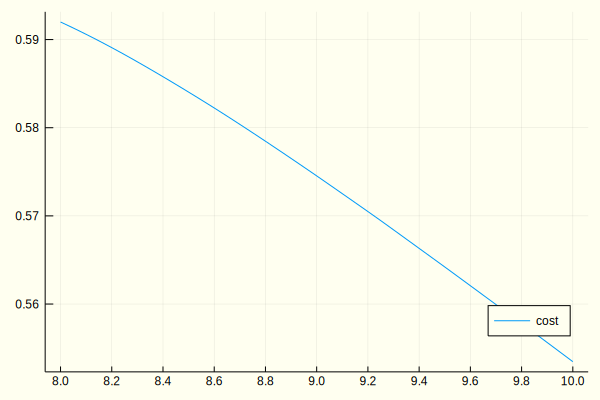

In [13]:
plot(lambda_range,ssims,label="cost",xticks = 0:0.2:lambda_max, background_color = :ivory, legend=:bottomright)

## Gradient Calculation
Let us consider a reduced cost function

$$
j(\lambda) = \frac{1}{2}\|S(\lambda)-z\|^2+\frac{\alpha}{2}\|\lambda\|^2,
$$

its directional derivative will be given by

$$
j'(\lambda)h = \langle S(\lambda)-z, S'(\lambda)h \rangle + \alpha \langle \lambda, h \rangle
$$

In [29]:
include("gradient_solver.jl")

gradient_solver (generic function with 2 methods)

In [41]:
λ = 10
radius = 10
∇ = gradient_matrix(size(f))
u_h= lower_level_solver(f,λ,K)
grad = gradient_solver(u_h,f,z,λ,α,K,∇,radius)

-0.39435400776273366

In [39]:
step = 0.1
lambda_max = 10
lambda_min = 2
lambda_range = lambda_min:step:lambda_max
grads = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(f,λ,K)
    g = gradient_solver(u_h,f,z,λ,α,K,∇,radius)
    push!(grads,g)
    if λ % 2 == 0
        print("$(round(λ,digits=3)), ")
    end
end

2.0, 4.0, 6.0, 8.0, 

Task (runnable) @0x0000000116326f50

10.0, 

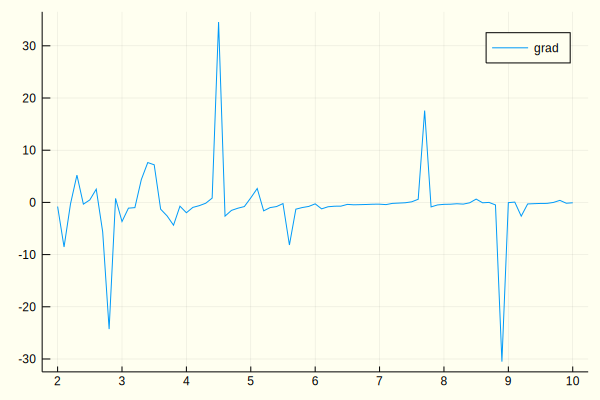

In [40]:
plot(lambda_range,grads,label="grad",xticks = 0:1:lambda_max, background_color = :ivory, legend=:topright)
#plot!(lambda_range,costs,label="cost",xticks = 0:5:lambda_max, background_color = :ivory, legend=:bottomright)

## Trust Region Algorithm
We will use a nonsmooth trust region strategy to solve this problem. This method will consider a local quadratic model described by 

$$
q_k(s) = j(\lambda_k)+g_k^\top s + \frac{1}{2}s^\top H_k s
$$

where $s$ is the descent direction, $g_k$ will be the gradient at iteration $k$ and $H_k$ will be a matrix with second order information that can be obtained using SR1 or BFGS method.
The trust region radius will be $\Delta_k$ and the actual and predicted reductions are given by

$$
ared(s_k) := j(\lambda_k)-j(\lambda_k+s_k),\;pred(s_k) := j(\lambda_k)-q_k(s_k)
$$

and the step quality will be given by the following quotient

$$
\rho_k(s_k) = \frac{ared(s_k)}{pred(s_k)}
$$

In [198]:
include("trust_region_solver.jl")

trust_region_solver (generic function with 1 method)

In [203]:
lambda_0 = 8
radius_0 = 5
tol = 1e-6
check = 1

1

In [204]:
model = 1
lambda_opt_1 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model,check)

TR Iteration 1: 	lambda = 8.0, rho_k = -0.017, radius = 5, g_k = -2.878, s_k = 5.0, H_k = 0.0
TR Iteration 2: 	lambda = 8.0, rho_k = 0.007, radius = 2.5, g_k = -2.878, s_k = 2.5, H_k = 0.0
TR Iteration 3: 	lambda = 8.0, rho_k = 0.022, radius = 1.25, g_k = -2.878, s_k = 1.25, H_k = 0.0
TR Iteration 4: 	lambda = 8.0, rho_k = 0.031, radius = 0.625, g_k = -2.878, s_k = 0.625, H_k = 0.0
TR Iteration 5: 	lambda = 8.0, rho_k = 0.035, radius = 0.3125, g_k = -2.878, s_k = 0.312, H_k = 0.0
TR Iteration 6: 	lambda = 8.0, rho_k = 0.038, radius = 0.15625, g_k = -2.878, s_k = 0.156, H_k = 0.0
TR Iteration 7: 	lambda = 8.0, rho_k = 0.456, radius = 0.078125, g_k = -0.247, s_k = 0.078, H_k = 0.0
TR Iteration 8: 	lambda = 8.0781, rho_k = 0.711, radius = 0.15625, g_k = -0.143, s_k = 0.156, H_k = 0.0
TR Iteration 9: 	lambda = 8.2344, rho_k = -0.237, radius = 0.3125, g_k = 0.462, s_k = -0.312, H_k = 0.0
TR Iteration 10: 	lambda = 8.2344, rho_k = -0.221, radius = 0.15625, g_k = 0.462, s_k = -0.156, H_k = 0.

9.40625

0.5502606778022745, 5.517607590950259
0.2704991908102393, 10.297262025548765


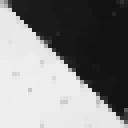

In [205]:
u_h = lower_level_solver(u,f,lambda_opt_1,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_1,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_1,α))")
Gray.(u_h)

In [206]:
model = 2 # SR1 Model
lambda_opt_2 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model,check)

TR Iteration 1: 	lambda = 8.0, rho_k = -0.018, radius = 5, g_k = -2.878, s_k = 5.0, H_k = 0.1
TR Iteration 2: 	lambda = 8.0, rho_k = 0.007, radius = 2.5, g_k = -2.878, s_k = 2.5, H_k = 0.1
TR Iteration 3: 	lambda = 8.0, rho_k = 0.023, radius = 1.25, g_k = -2.878, s_k = 1.25, H_k = 0.1
TR Iteration 4: 	lambda = 8.0, rho_k = 0.031, radius = 0.625, g_k = -2.878, s_k = 0.625, H_k = 0.1
TR Iteration 5: 	lambda = 8.0, rho_k = 0.036, radius = 0.3125, g_k = -2.878, s_k = 0.312, H_k = 0.1
TR Iteration 6: 	lambda = 8.0, rho_k = 0.038, radius = 0.15625, g_k = -2.878, s_k = 0.156, H_k = 0.1
TR Iteration 7: 	lambda = 8.0, rho_k = 0.463, radius = 0.078125, g_k = -0.247, s_k = 0.078, H_k = 0.1
TR Iteration 8: 	lambda = 8.0781, rho_k = 2.59, radius = 0.15625, g_k = -0.143, s_k = 0.156, H_k = 1.33
TR Iteration 9: 	lambda = 8.2344, rho_k = 0.762, radius = 0.3125, g_k = 0.462, s_k = -0.312, H_k = 3.87
TR Iteration 10: 	lambda = 7.9219, rho_k = 0.535, radius = 0.625, g_k = -0.334, s_k = 0.086, H_k = 2.55


TR Iteration 78: 	lambda = 8.6292, rho_k = 0.0, radius = 0.0006103515625, g_k = -0.023, s_k = 0.0, H_k = 2.920335068798599e13
TR Iteration 79: 	lambda = 8.6292, rho_k = 0.0, radius = 0.00030517578125, g_k = -0.023, s_k = 0.0, H_k = 2.920335068798599e13
TR Iteration 80: 	lambda = 8.6292, rho_k = 0.0, radius = 0.000152587890625, g_k = -0.023, s_k = 0.0, H_k = 2.920335068798599e13
TR Iteration 81: 	lambda = 8.6292, rho_k = 0.0, radius = 7.62939453125e-5, g_k = -0.023, s_k = 0.0, H_k = 2.920335068798599e13
TR Iteration 82: 	lambda = 8.6292, rho_k = 0.0, radius = 3.814697265625e-5, g_k = -0.023, s_k = 0.0, H_k = 2.920335068798599e13
TR Iteration 83: 	lambda = 8.6292, rho_k = 0.0, radius = 1.9073486328125e-5, g_k = -0.023, s_k = 0.0, H_k = 2.920335068798599e13
TR Iteration 84: 	lambda = 8.6292, rho_k = 0.0, radius = 9.5367431640625e-6, g_k = -0.023, s_k = 0.0, H_k = 2.920335068798599e13
TR Iteration 85: 	lambda = 8.6292, rho_k = 0.0, radius = 4.76837158203125e-6, g_k = -0.023, s_k = 0.0, H_k

8.62917613171539

0.570096987426224, 5.543573760878814
0.2704991908102393, 10.227187733797098


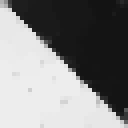

In [208]:
u_h = lower_level_solver(u,f,lambda_opt_2,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_2,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_2,α))")
Gray.(u_h)

In [168]:
model = 3
lambda_opt_3 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model,check)

TR Iteration 1: 	lambda = 400.0, rho_k = 1.001, radius = 0.1, g_k = 4.001, s_k = -0.1, H_k = 0.1
TR Iteration 2: 	lambda = 399.9, rho_k = 1.0, radius = 0.2, g_k = 4.0, s_k = -0.2, H_k = 0.01
TR Iteration 3: 	lambda = 399.7, rho_k = 1.0, radius = 0.4, g_k = 3.998, s_k = -0.4, H_k = 0.01
TR Iteration 4: 	lambda = 399.3, rho_k = 1.0, radius = 0.8, g_k = 3.994, s_k = -0.8, H_k = 0.01
TR Iteration 5: 	lambda = 398.5, rho_k = 1.0, radius = 1.6, g_k = 3.986, s_k = -1.6, H_k = 0.01
TR Iteration 6: 	lambda = 396.9, rho_k = 1.0, radius = 3.2, g_k = 3.97, s_k = -3.2, H_k = 0.01
TR Iteration 7: 	lambda = 393.7, rho_k = 1.0, radius = 6.4, g_k = 3.938, s_k = -6.4, H_k = 0.01
TR Iteration 8: 	lambda = 387.3, rho_k = 1.0, radius = 12.8, g_k = 3.874, s_k = -12.8, H_k = 0.01
TR Iteration 9: 	lambda = 374.5, rho_k = 1.0, radius = 25.6, g_k = 3.746, s_k = -25.6, H_k = 0.01
TR Iteration 10: 	lambda = 348.9, rho_k = 1.0, radius = 51.2, g_k = 3.49, s_k = -51.2, H_k = 0.01
TR Iteration 11: 	lambda = 297.7, rh

6.876618986388056

0.6019067583984108, 5.796152783571229
0.2704991908102393, 10.09131377365603


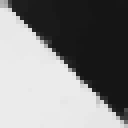

In [207]:
u_h = lower_level_solver(u,f,lambda_opt_3,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_3,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_3,α))")
Gray.(u_h)

0.5480135718275991
0.27781438267156516


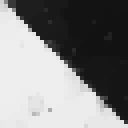

In [131]:
u_h = lower_level_solver(u,f,9.47,K)
println(ssim(u_h,z))
println(ssim(f,z))
Gray.(u_h)